In [16]:
import os
from tqdm import tqdm
import pickle
import random
from typing import List, Dict, Tuple
from anndata import AnnData

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import seaborn as sns

import metaspace
import linex2metaspace as lx2m
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from statannotations.Annotator import Annotator
import networkx as nx

In [3]:
import utils
from config import store_dir, data_dir, date_key, enrichment_dir
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
pos_lip_top_datasets = pickle.load(open(os.path.join(store_dir, 'pos_lip_top_datasets_list.pickle'), "rb" ))

# Helper functions

In [101]:
def load_tissue_datasets(ds_list: list, include_offsample: bool=False, fdr: float=0.1, path=os.path.join(store_dir, 'all_ionimages/')) -> Dict[str, AnnData]:
    out_ads = {}
    for ds in ds_list:
        out_ads[ds] = pickle.load(open(os.path.join(path, f'{ds}.pickle'), "rb" ))
        if not include_offsample:
            out_ads[ds] = out_ads[ds][:, out_ads[ds].var['offSample'] == False]
        out_ads[ds] = out_ads[ds][:, out_ads[ds].var['fdr'] <= fdr]
    
    return out_ads

def compute_colocs(ads: Dict[str, AnnData]) -> Tuple[Dict[str, pd.DataFrame], Dict[str, List]]:
    
    molecule_names = {}
    coloc_dict = {}

    for dsid, adat in ads.items():

        unique_labels = np.unique(adat.var.formula)
        sums = {}

        # Iterate over the unique labels
        for label in unique_labels:
            # Get the indices of rows with the current label
            indices = np.where(adat.var.formula == label)[0]
            # Sum up the corresponding rows and store the result
            if len(indices)>1:
                sums[label] = np.sum(adat.X[:, indices], axis=1)
            else:
                sums[label] = adat.X[:, indices[0]]

            molecule_names[label] = adat.var[adat.var['formula']==label]['moleculeNames'][0]

        tmp_array = np.stack(list(sums.values()))
        tmp_molecules = np.array(list(sums.keys()))
        tmp_ymax = adat.obs['y'].max()+1

        # Coloc preprocessing:
        conv_data = utils.coloc_preprocessing_array(tmp_array.transpose(), tmp_ymax)

        coloc = pairwise_kernels(conv_data, metric='cosine')

        coloc_df = pd.DataFrame(coloc, columns=tmp_molecules, index=tmp_molecules)

        coloc_dict[dsid] = coloc_df
        
    return coloc_dict, molecule_names

def list_same_colocs(coloc_dict: Dict[str, pd.DataFrame]) -> Dict[Tuple[str, str], List[float]]:
    ii_dict = {}
    for ds in coloc_dict.values():
        idx = list(ds.index)
        for ion1 in range(len(idx)):
            for ion2 in range(ion1, len(idx)):
                if idx[ion1] != idx[ion2]:
                    tmp = tuple(sorted([idx[ion1], idx[ion2]]))
                    if tmp in ii_dict.keys():
                        ii_dict[tmp].append(ds.loc[idx[ion1], idx[ion2]])
                    else:
                        ii_dict[tmp] = [ds.loc[idx[ion1], idx[ion2]]]
                        
    return ii_dict


def coloc_measures(ii_dict: Dict[Tuple[str, str], List[float]],
                   min_datasets: int=10
                  ):
    mean_l = []
    var_l = []
    cv_l = []
    cooc_l = []
    ion_paris = []

    for ii, x in ii_dict.items():
        if len(x) >= min_datasets:
            if not all(np.array(x)==0):
                mean_l.append(np.mean(x))
                var_l.append(np.var(x))
                cv_l.append(np.std(x)/np.mean(x))
                cooc_l.append(len(x))
                ion_paris.append(ii)
    
    return pd.DataFrame({'mean': mean_l, 'variance': var_l, 'cv': cv_l, 'coocurrence': cooc_l, 'ion_pairs': ion_paris})

def compute_lx_nets(coloc_dict: Dict[str, pd.DataFrame], molecule_names: Dict[str, List], ref_lip_dict, class_reacs, bootstraps: int=30):
    lx_nets = {}
    lx_annotations = {}

    for dsid in coloc_dict.keys():

        tmp_annotations = pd.Series({x: molecule_names[x] for x in coloc_dict[dsid].columns})

        parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                                     ref_lip_dict, 
                                                     verbose=False) # True if you want to see all lipids that were not parsed

        keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
        parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
        parsed_annotations = parsed_annotations.loc[keep_annotations,:]


        net = lx2m.bootstrap_networks(lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                                      parsed_annotations['parsed_lipids'], 
                                      n=bootstraps, 
                                      lx2_class_reacs=class_reacs, 
                                      lx2_reference_lipids=lx2m.get_lx2_ref_lips(), 
                                      return_composed=True)


        ion_net = lx2m.ion_weight_graph(net, 
                                        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                                        bootstraps=bootstraps, 
                                        parsed_lipids=parsed_annotations['parsed_lipids'])

        lx_nets[dsid] = ion_net
        lx_annotations[dsid] = parsed_annotations
        
    return lx_nets, lx_annotations

def catch_sp(g, source, target):
    try:
        return nx.shortest_path_length(g, source, target)
    except nx.NetworkXNoPath:
        return np.inf

# Load datasets

In [9]:
brain_ads = load_tissue_datasets(pos_lip_top_datasets['Brain'].index)

In [11]:
# exclude datasets

del brain_ads['2022-08-24_00h20m06s']
del brain_ads['2022-08-23_23h48m59s']

In [12]:
len(brain_ads)

28

# Compute colocs

In [20]:
# Sum molecule intensities over adducts
# Save required info for preprocessing & coloc: Array, y-size, moleculeNames

coloc_dict, molecule_names = compute_colocs(brain_ads)

In [21]:
cl = []
for dsid, clc in coloc_dict.items():
    tmp = clc.melt().drop(columns=['variable'])
    tmp['ds']=dsid
    cl.append(tmp)

## Coloc robustness

In [26]:
ii_dict = list_same_colocs(coloc_dict)
                

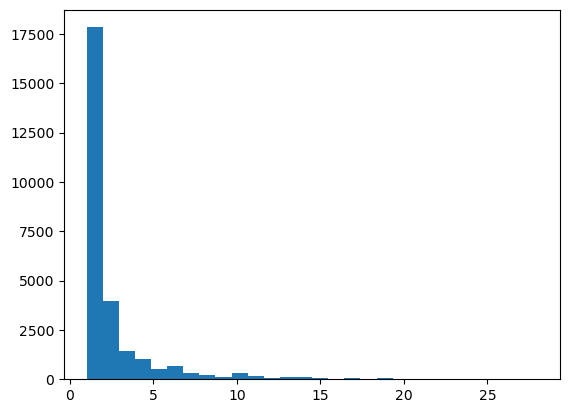

In [27]:
plt.hist([len(x) for x in ii_dict.values()], bins=28)
plt.show()

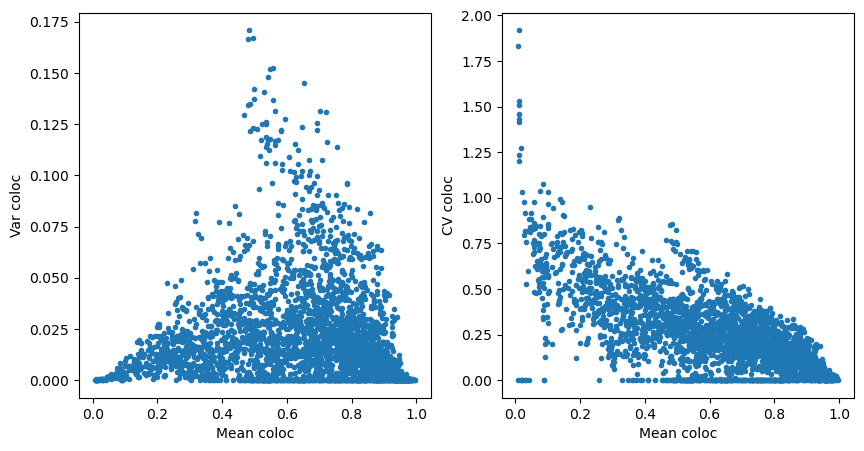

In [31]:
c_measures = coloc_measures(ii_dict, min_datasets=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(c_measures['mean'], c_measures['variance'], '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

ax2.plot(c_measures['mean'], c_measures['cv'], '.')
ax2.set_xlabel('Mean coloc')
ax2.set_ylabel('CV coloc')
plt.show()


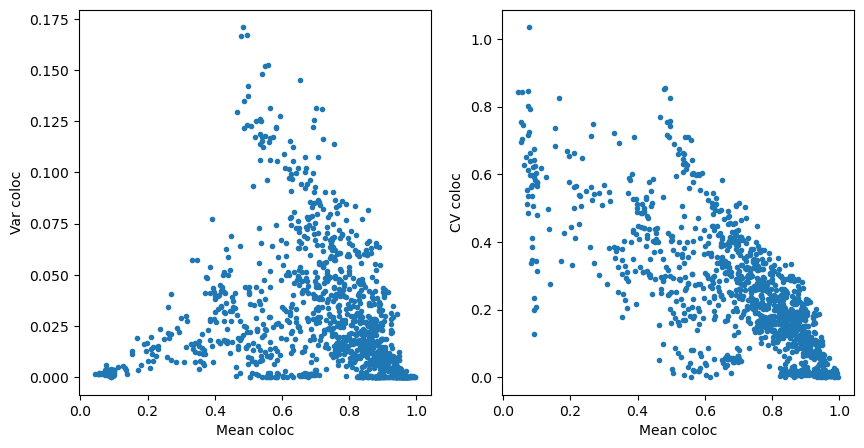

In [32]:
c_measures = coloc_measures(ii_dict, min_datasets=10)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(c_measures['mean'], c_measures['variance'], '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

ax2.plot(c_measures['mean'], c_measures['cv'], '.')
ax2.set_xlabel('Mean coloc')
ax2.set_ylabel('CV coloc')
plt.show()

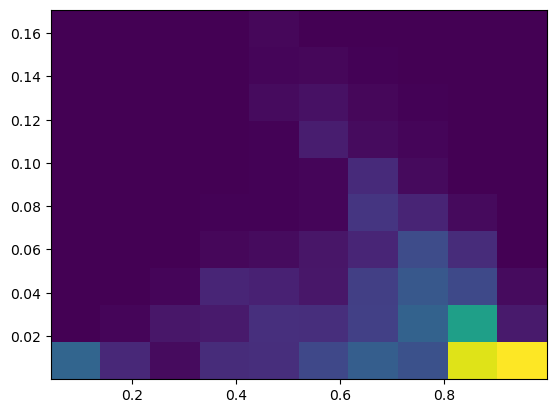

In [33]:
plt.hist2d(c_measures['mean'], c_measures['variance'])
plt.show()

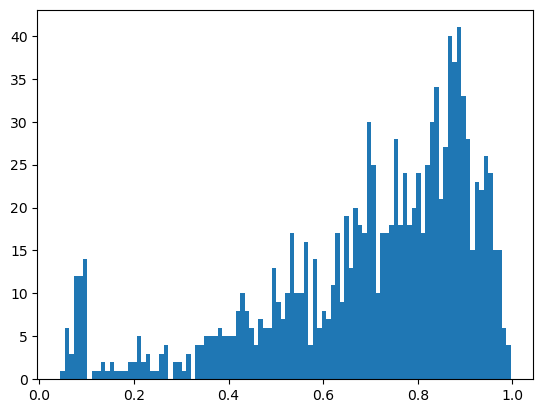

In [34]:
plt.hist(c_measures['mean'], bins=100)
plt.show()

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


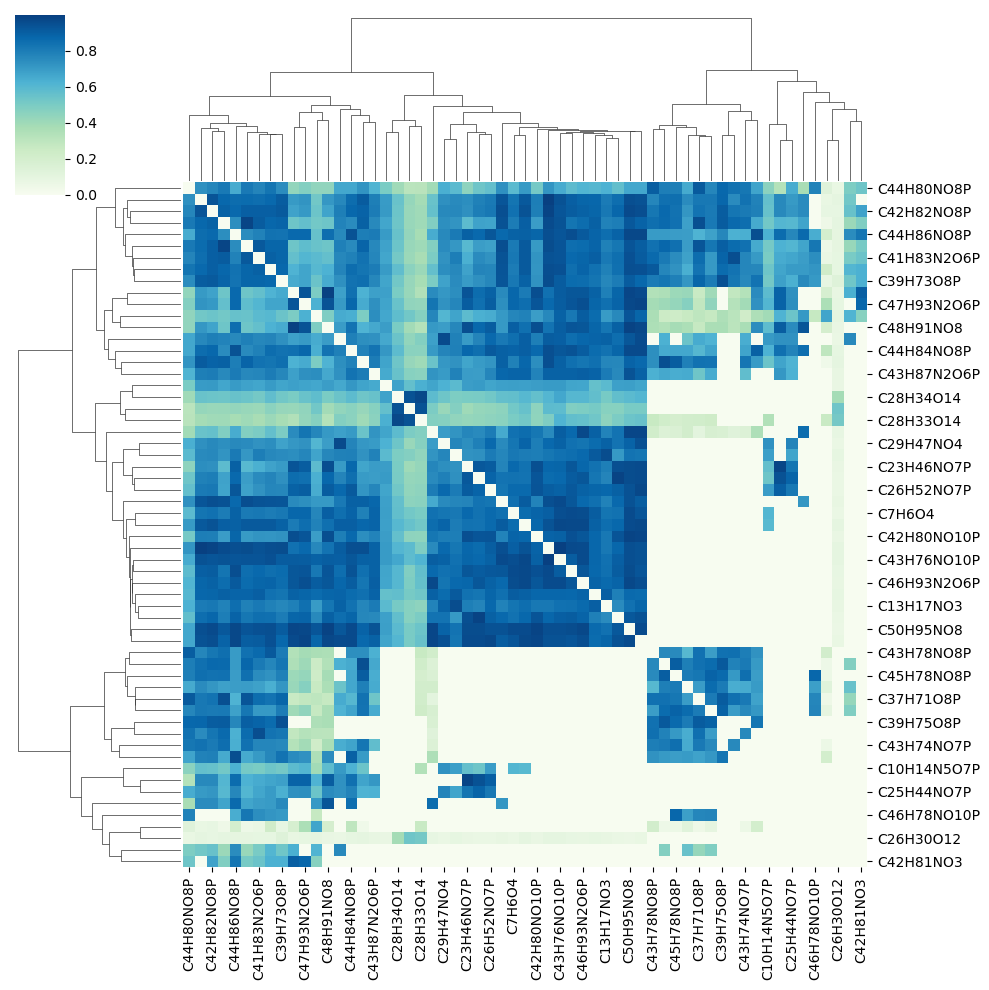

In [38]:
c_measures = coloc_measures(ii_dict, min_datasets=10)
            
selected_ions = list(set([item for tup in c_measures['ion_pairs'] for item in tup]))

df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)

for x in range(c_measures.shape[0]):
    c_measures['ion_pairs'][x][0], c_measures['ion_pairs'][x][1]
    df.loc[c_measures['ion_pairs'][x][0], c_measures['ion_pairs'][x][1]] = c_measures['mean'][x]
    df.loc[c_measures['ion_pairs'][x][1], c_measures['ion_pairs'][x][0]] = c_measures['mean'][x]

a = sns.clustermap(df, cmap='GnBu')

In [18]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustering_labels = hierarchical_cluster.fit_predict(df)

clustering_labels

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([2, 2, 1, 1, 0, 2, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 1, 1,
       0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1, 2, 1,
       0, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0, 1, 1])

## Coloc vs. co-occurrence

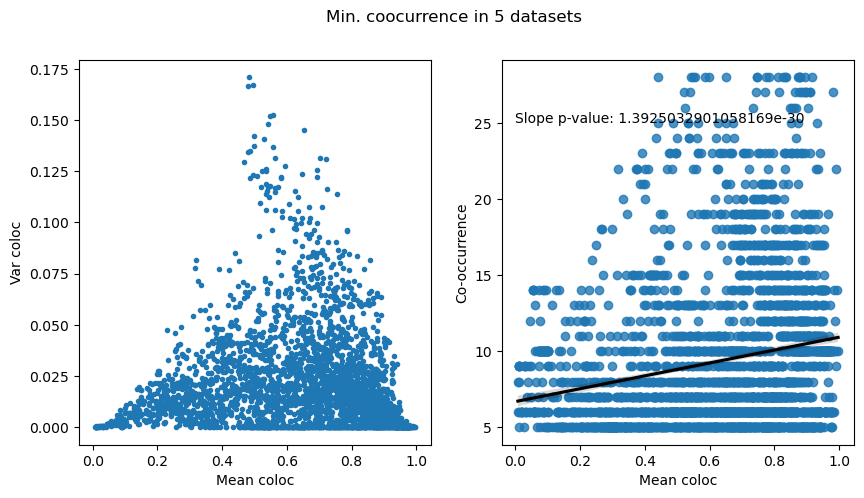

1.3925032901058169e-30

In [42]:
c_measures = coloc_measures(ii_dict, min_datasets=5)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(c_measures['mean'], c_measures['variance'], '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

fig.suptitle(f'Min. coocurrence in {min_datasets} datasets')

sns.regplot(x="mean", y="coocurrence", data=c_measures, ax=ax2, line_kws={"color": "black"})
#ax2.hist2d(mean_l, cooc_l)
ax2.set_xlabel('Mean coloc')
ax2.set_ylabel('Co-occurrence')
pval = stats.linregress(c_measures['mean'], c_measures['coocurrence']).pvalue
ax2.text(0.0, list(ax2.get_yticklabels()[-2].get_position())[1], f'Slope p-value: {pval}')
plt.show()

stats.linregress(c_measures['mean'], c_measures['coocurrence']).pvalue

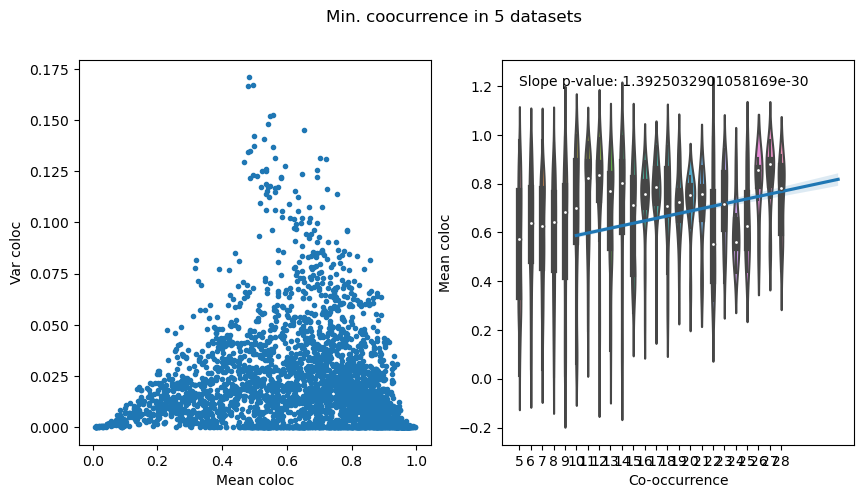

In [44]:
c_measures = coloc_measures(ii_dict, min_datasets=5)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(c_measures['mean'], c_measures['variance'], '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

fig.suptitle(f'Min. coocurrence in {min_datasets} datasets')

sns.violinplot(x="coocurrence", y="mean", data=c_measures, ax=ax2)
sns.regplot(x="coocurrence", y="mean", data=c_measures, ax=ax2, scatter=False)

#ax2.hist2d(mean_l, cooc_l)
ax2.set_xlabel('Co-occurrence')
ax2.set_ylabel('Mean coloc')
pval = stats.linregress(c_measures['coocurrence'], c_measures['mean']).pvalue
ax2.text(0.0, list(ax2.get_yticklabels()[-2].get_position())[1], f'Slope p-value: {pval}')
plt.show()

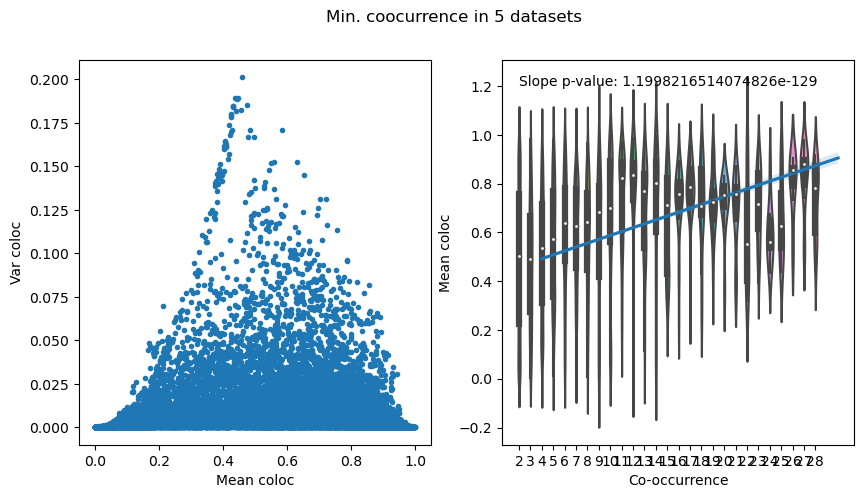

In [46]:
c_measures = coloc_measures(ii_dict, min_datasets=2)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
            
ax1.plot(c_measures['mean'], c_measures['variance'], '.')
ax1.set_xlabel('Mean coloc')
ax1.set_ylabel('Var coloc')

fig.suptitle(f'Min. coocurrence in {min_datasets} datasets')

sns.violinplot(x="coocurrence", y="mean", data=c_measures, ax=ax2)
sns.regplot(x="coocurrence", y="mean", data=c_measures, ax=ax2, scatter=False)

#ax2.hist2d(mean_l, cooc_l)
ax2.set_xlabel('Co-occurrence')
ax2.set_ylabel('Mean coloc')
pval = stats.linregress(c_measures['coocurrence'], c_measures['mean']).pvalue
ax2.text(0.0, list(ax2.get_yticklabels()[-2].get_position())[1], f'Slope p-value: {pval}')
plt.show()

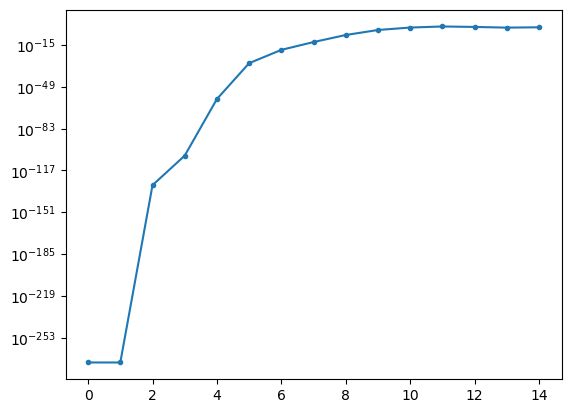

In [48]:
min_ds = []
pvals = []
for i in range(15):
    c_measures = coloc_measures(ii_dict, min_datasets=i)
                
    if len(mean_l) > 2:
        pvals.append(stats.linregress(c_measures['coocurrence'], c_measures['mean']).pvalue)
        min_ds.append(i)
    
plt.plot(min_ds, pvals, '.-')
plt.yscale('log')

## Coloc vs. LINEX

In [86]:
# LINEX2 preprocessing
ref_lip_dict = lx2m.get_lx2_ref_lip_dict()
class_reacs = lx2m.get_organism_combined_class_reactions(ref_lip_dict=ref_lip_dict, organism='HSA')

In [87]:
lx_nets, lx_annotations = compute_lx_nets(coloc_dict, molecule_names, ref_lip_dict, class_reacs, bootstraps=30)

1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:5.063e-41 U_stat=7.287e+07


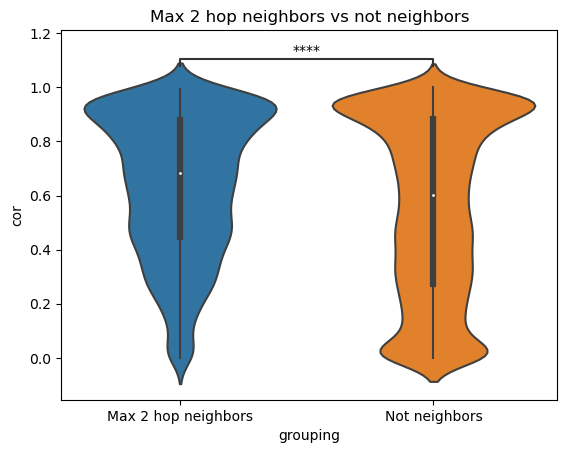

In [102]:
edge_cor = []
nedge_cor = []
eds_l = []
nds_l = []

for dsid in lx_nets.keys():
    
    ls = coloc_dict[dsid]
    #led = list(ig.edges)
    ig = lx_nets[dsid]

    max_hops = 2
    node_list = list(lx_nets[dsid].nodes)
    for l1 in range(len(node_list)):
        for l2 in range(l1+1, len(node_list)):
            if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                eds_l.append(dsid)
            else:
                nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                nds_l.append(dsid)

tmp_dat = pd.concat([
    pd.DataFrame({'cor': edge_cor, 'grouping': 'Max '+str(max_hops)+' hop neighbors', 'dataset': eds_l}),
    pd.DataFrame({'cor': nedge_cor, 'grouping': 'Not neighbors', 'dataset': nds_l}),
          ])

ax = sns.violinplot(data=tmp_dat, x='grouping', y='cor')

annotator = Annotator(ax, 
                      [('Max '+str(max_hops)+' hop neighbors', 'Not neighbors')], 
                      data=tmp_dat, x='grouping', y='cor', 
                      order=['Max '+str(max_hops)+' hop neighbors', 'Not neighbors'])
annotator.configure(test="Mann-Whitney")
annotator.apply_and_annotate()

plt.title('Max '+str(max_hops)+' hop neighbors vs not neighbors')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:3.000e-13 U_stat=3.423e+06


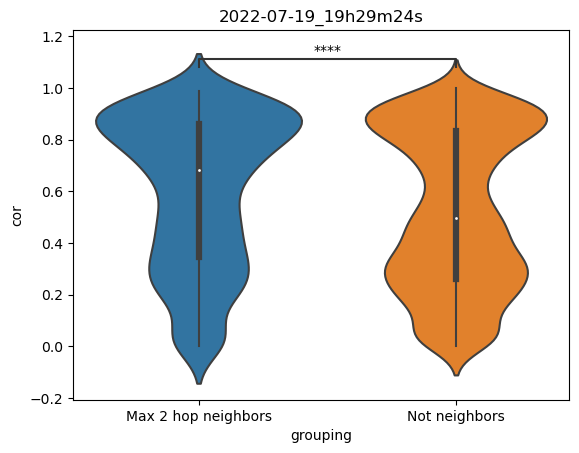

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.638e-06 U_stat=1.098e+04


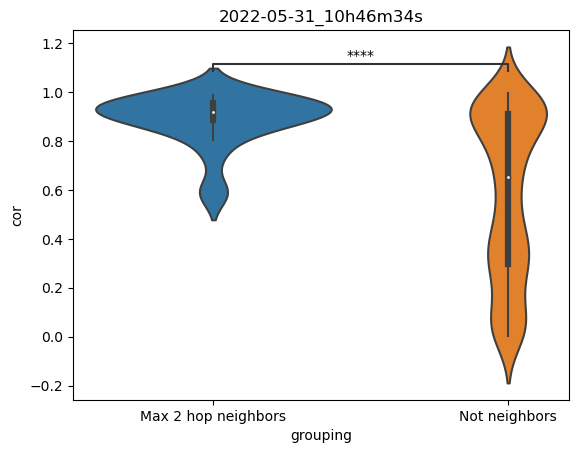

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:2.919e-01 U_stat=3.678e+04


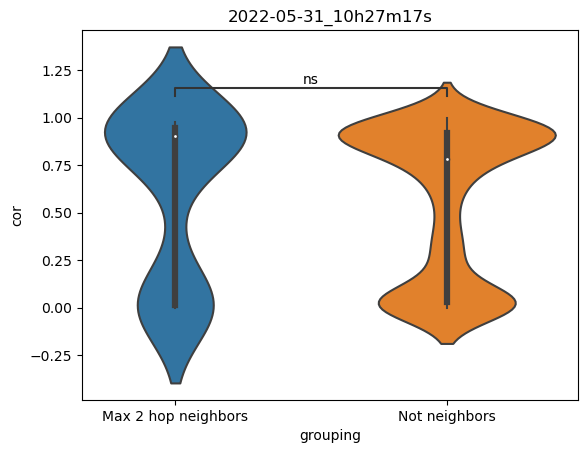

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:2.035e-02 U_stat=1.102e+04


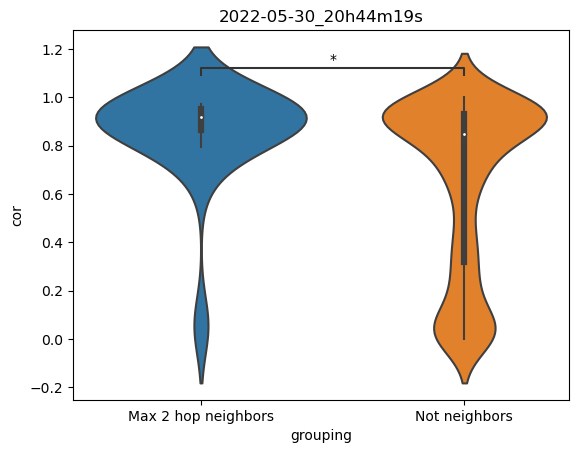

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.640e-02 U_stat=8.680e+02


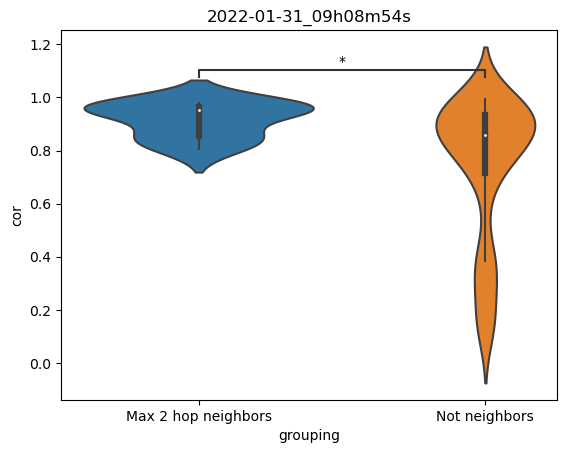

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.437e-02 U_stat=1.213e+03


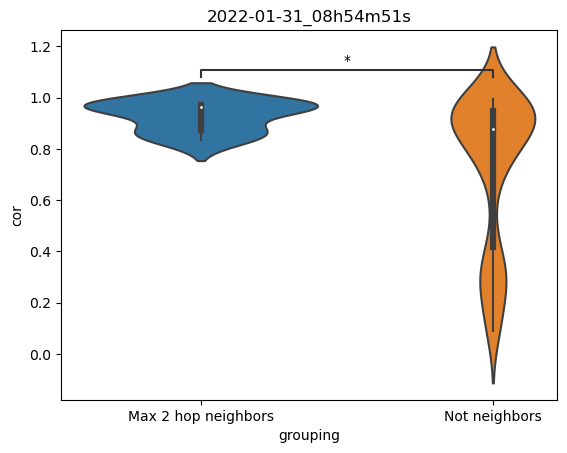

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.335e-07 U_stat=3.083e+05


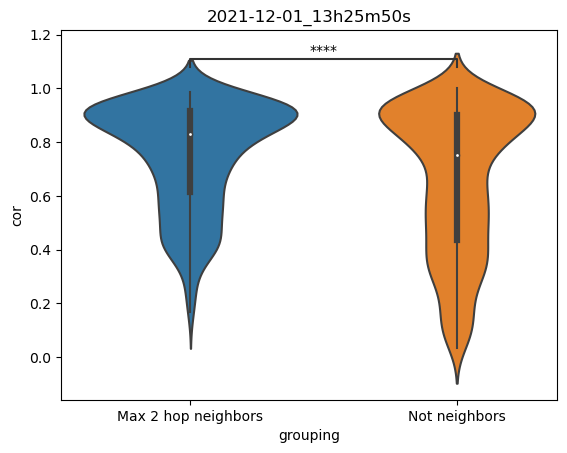

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.669e-07 U_stat=3.618e+05


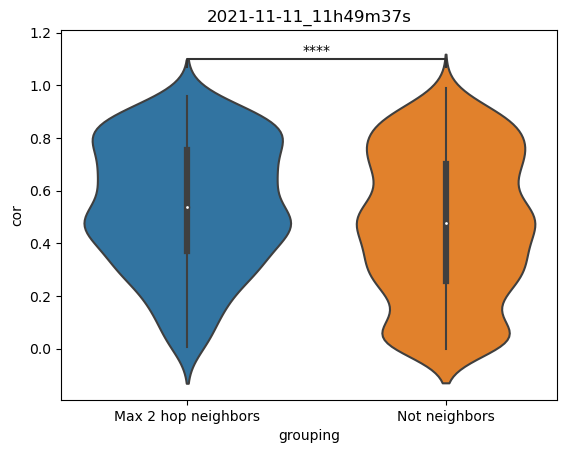

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:5.230e-04 U_stat=8.127e+04


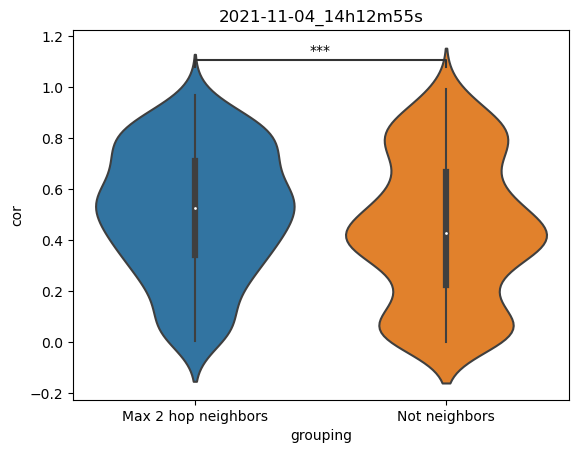

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.737e-03 U_stat=1.349e+04


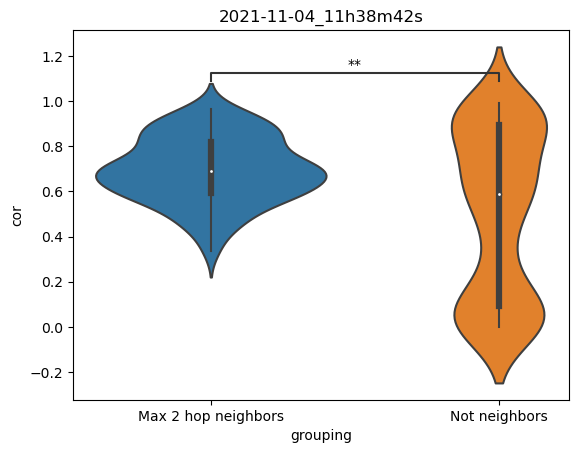

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.916e-06 U_stat=2.485e+04


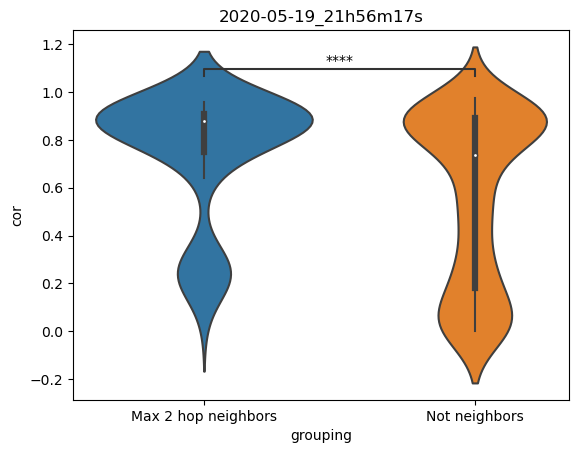

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.902e-02 U_stat=1.219e+04


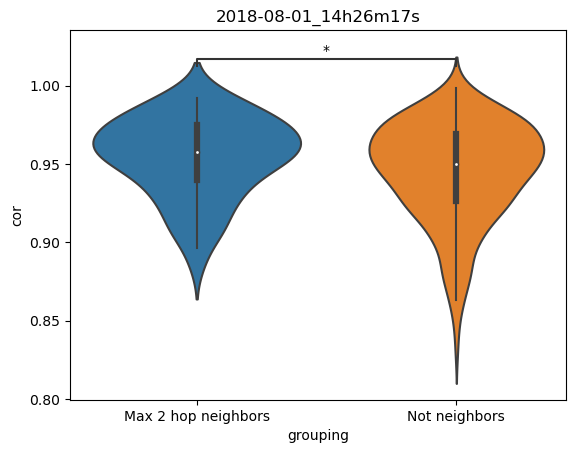

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.902e-02 U_stat=1.219e+04


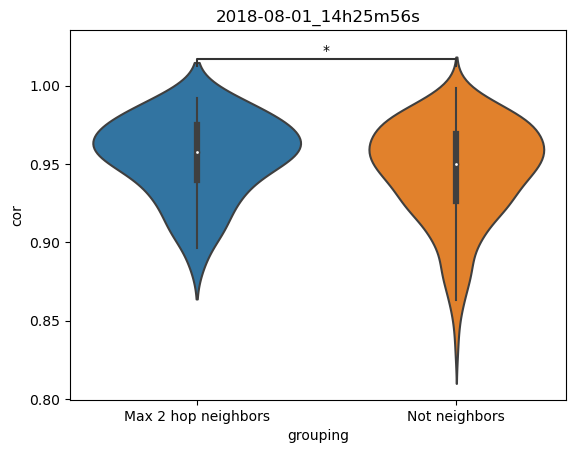

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.902e-02 U_stat=1.219e+04


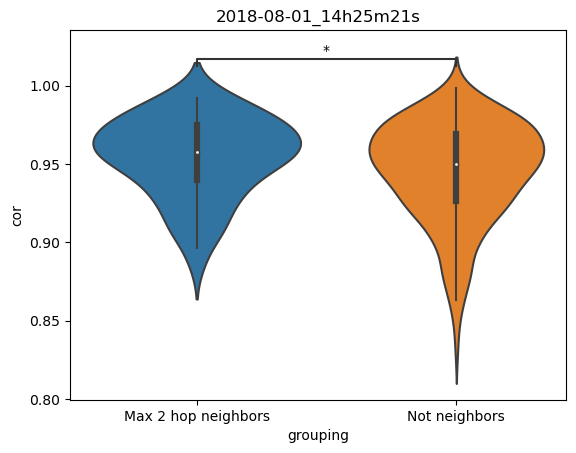

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.132e-01 U_stat=8.526e+03


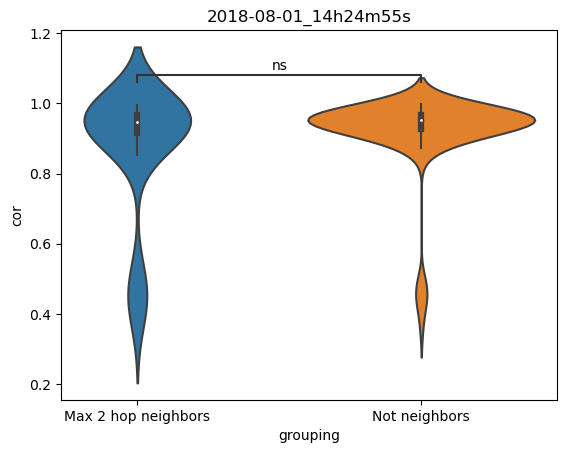

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.132e-01 U_stat=8.526e+03


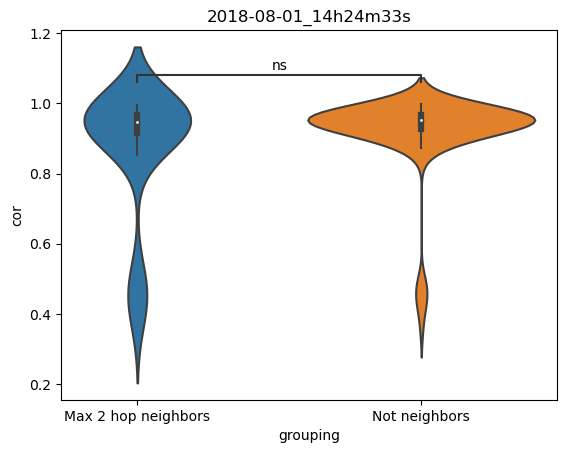

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.132e-01 U_stat=8.526e+03


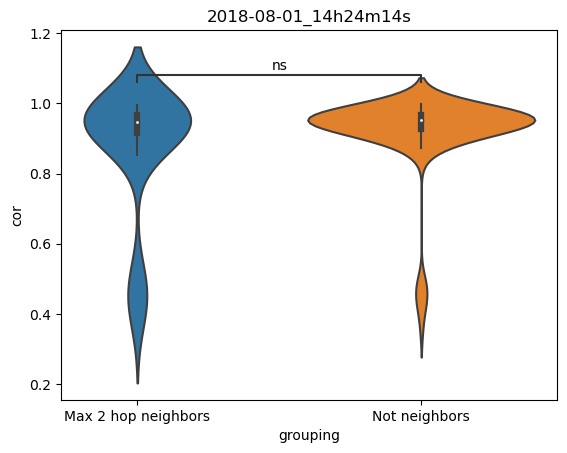

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.902e-02 U_stat=1.219e+04


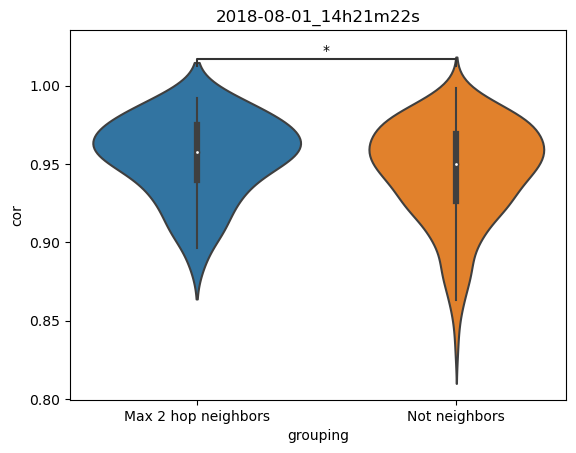

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.132e-01 U_stat=8.526e+03


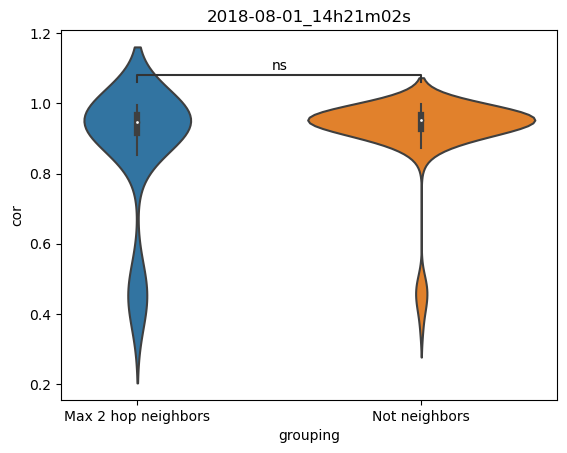

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.132e-01 U_stat=8.526e+03


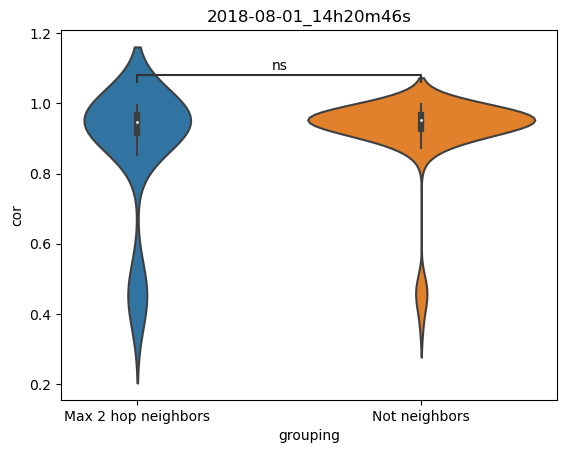

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.132e-01 U_stat=8.526e+03


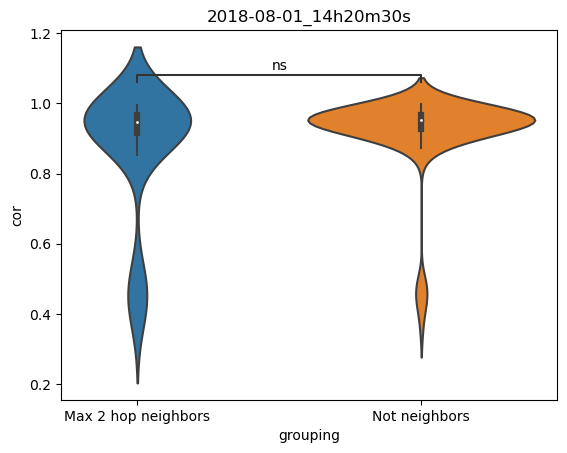

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:6.967e-10 U_stat=2.561e+05


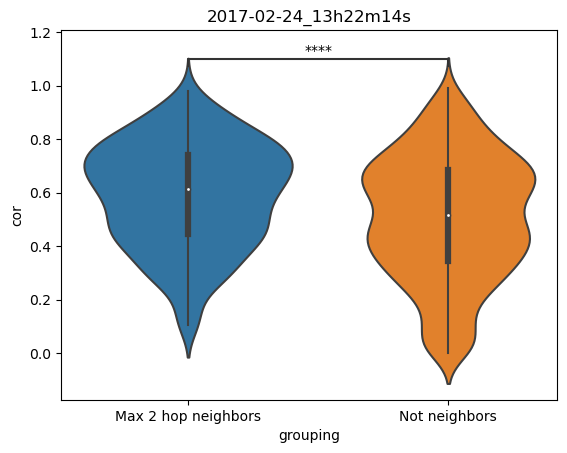

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.242e-57 U_stat=1.922e+06


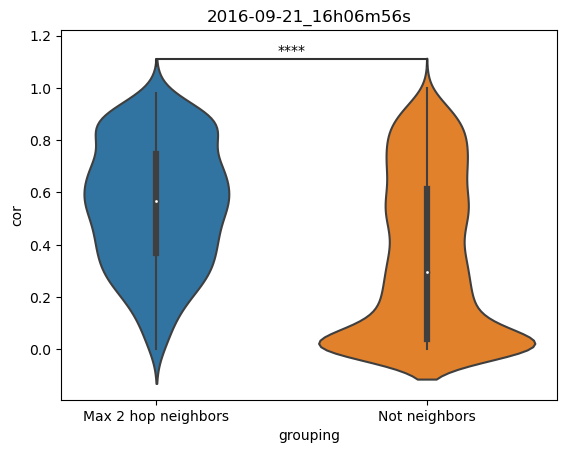

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.992e-08 U_stat=2.389e+05


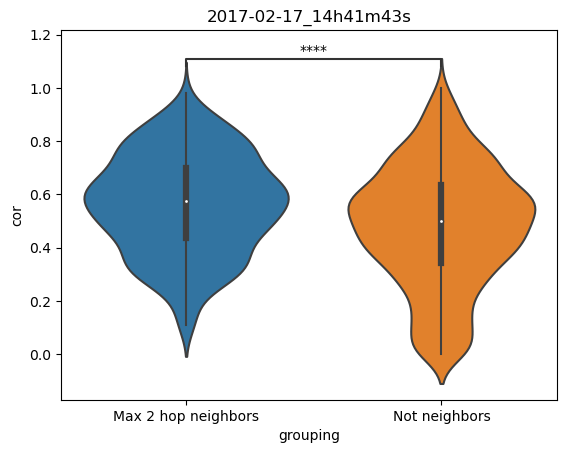

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.680e-13 U_stat=2.884e+05


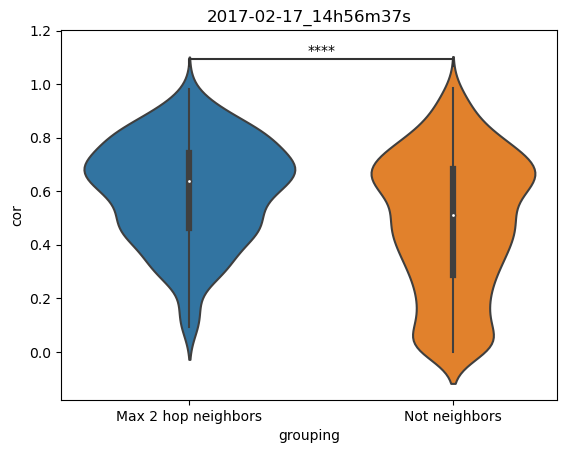

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.770e-10 U_stat=9.912e+04


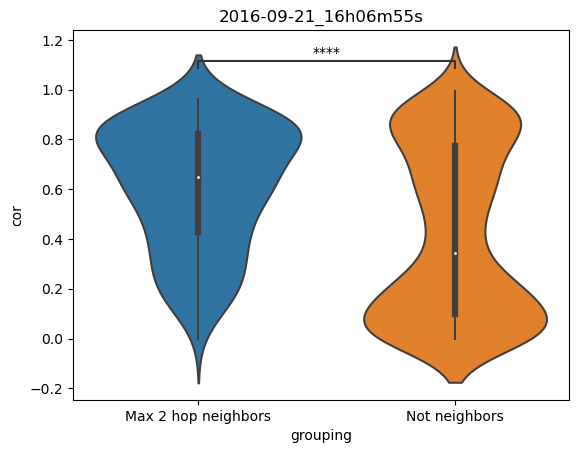

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:7.992e-09 U_stat=3.120e+04


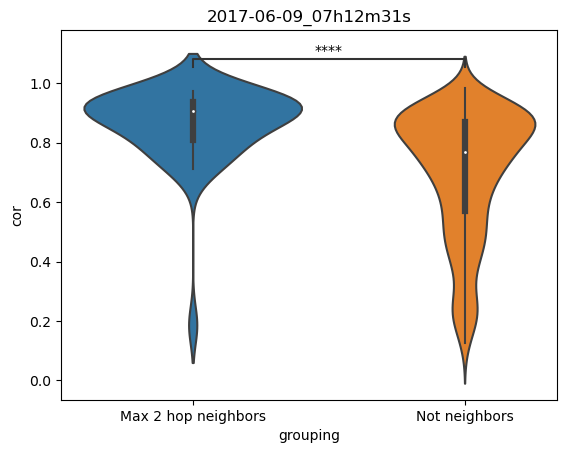

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Max 2 hop neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:4.324e-01 U_stat=6.030e+02


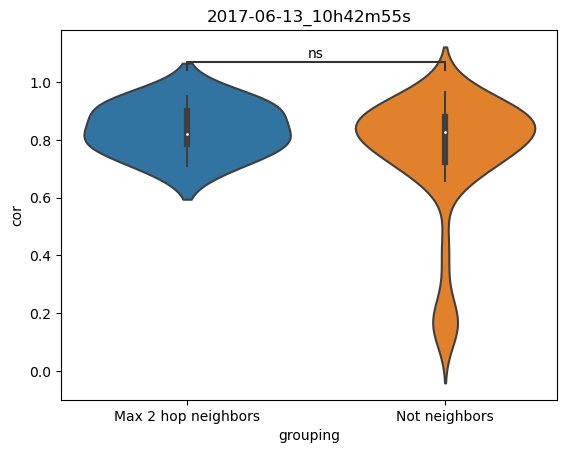

In [41]:


for dsid in lx_nets.keys():
    
    edge_cor = []
    nedge_cor = []
    eds_l = []
    nds_l = []
    ls = coloc_dict[dsid]
    #led = list(ig.edges)
    ig = lx_nets[dsid]

    max_hops = 2
    node_list = list(lx_nets[dsid].nodes)
    for l1 in range(len(node_list)):
        for l2 in range(l1+1, len(node_list)):
            if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                eds_l.append(dsid)
            else:
                nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                nds_l.append(dsid)

    tmp_dat = pd.concat([
        pd.DataFrame({'cor': edge_cor, 'grouping': 'Max '+str(max_hops)+' hop neighbors', 'dataset': eds_l}),
        pd.DataFrame({'cor': nedge_cor, 'grouping': 'Not neighbors', 'dataset': nds_l}),
              ])

    ax = sns.violinplot(data=tmp_dat, x='grouping', y='cor')

    annotator = Annotator(ax, 
                          [('Max '+str(max_hops)+' hop neighbors', 'Not neighbors')], 
                          data=tmp_dat, x='grouping', y='cor', 
                          order=['Max '+str(max_hops)+' hop neighbors', 'Not neighbors'])
    annotator.configure(test="Mann-Whitney")
    annotator.apply_and_annotate()

    plt.title(dsid)
    plt.show()

### N co-occurence networks

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
69 of 99 ions are part of the network


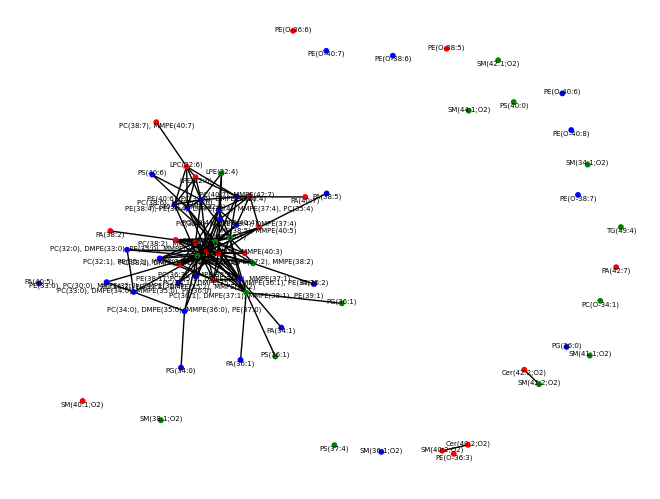

In [42]:
mean_d = {}
min_datasets = 5

counter = 0
for ii, x in ii_dict.items():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            if np.mean(x)>0.8 and np.var(x)<0.025:
                mean_d[ii] = np.mean(x)
            
selected_ions = list(set([item for tuple in mean_d for item in tuple]))


df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)
for k, v in mean_d.items():
    df.loc[k[0], k[1]] = v
    df.loc[k[1], k[0]] = v
    
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustering_labels = hierarchical_cluster.fit_predict(df)

tmp_annotations = pd.Series({x: molecule_names[x] for x in selected_ions})

parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                             ref_lip_dict, 
                                             verbose=False) # True if you want to see all lipids that were not parsed

keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
parsed_annotations = parsed_annotations.loc[keep_annotations,:]


bootstraps = 30

net = lx2m.bootstrap_networks(
        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']),
        parsed_annotations['parsed_lipids'],
        n=bootstraps,
        lx2_class_reacs=class_reacs,
        lx2_reference_lipids=lx2m.get_lx2_ref_lips(),
        return_composed=True
    )

label_cols = {0: 'blue', 1: 'green', 2: 'red'}
label_dict = {k: v for k, v in zip(df.columns, clustering_labels)}


ion_net = lx2m.ion_weight_graph(net, 
                           lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                           bootstraps=bootstraps,
                           parsed_lipids=parsed_annotations['parsed_lipids'],
                           #feature_similarity=feature_sim
                          )
print(f'{len(ion_net.nodes)} of {len(selected_ions)} ions are part of the network')

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + (y_shift * np.random.choice([-1,1]))) for n,(x,y) in pos.items()}

pos = nx.spring_layout(ion_net, k=.2)

nx.draw(ion_net, node_color=[label_cols[label_dict[n]] for n in ion_net], node_size=10, pos=pos)
nx.draw_networkx_labels(ion_net, pos=nudge(pos, 0, 0.01),
                            labels={k: ", ".join(v['sum_species'].index) for k, v in dict(ion_net.nodes(data=True)).items()},
                            font_size=5)
plt.show()

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
61 of 88 ions are part of the network


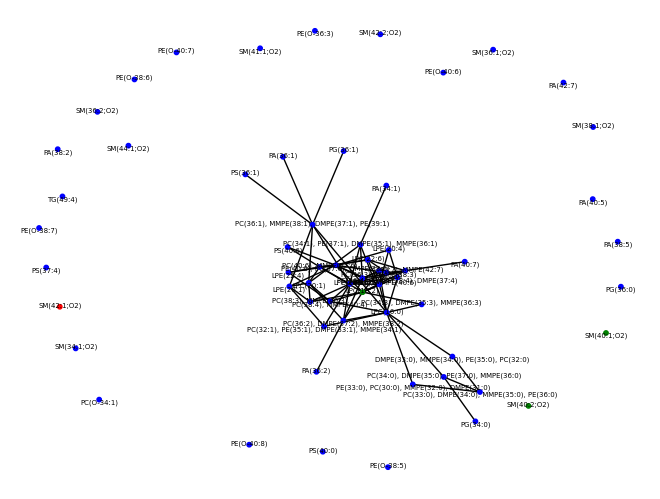

In [43]:
mean_d = {}
min_datasets = 5

counter = 0
for ii, x in ii_dict.items():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            if np.mean(x)<0.2 and np.var(x)<0.025:
                mean_d[ii] = np.mean(x)
            
selected_ions = list(set([item for tuple in mean_d for item in tuple]))


df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)
for k, v in mean_d.items():
    df.loc[k[0], k[1]] = v
    df.loc[k[1], k[0]] = v
    
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustering_labels = hierarchical_cluster.fit_predict(df)

tmp_annotations = pd.Series({x: molecule_names[x] for x in selected_ions})

parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                             ref_lip_dict, 
                                             verbose=False) # True if you want to see all lipids that were not parsed

keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
parsed_annotations = parsed_annotations.loc[keep_annotations,:]


bootstraps = 30

net = lx2m.bootstrap_networks(
        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']),
        parsed_annotations['parsed_lipids'],
        n=bootstraps,
        lx2_class_reacs=class_reacs,
        lx2_reference_lipids=lx2m.get_lx2_ref_lips(),
        return_composed=True
    )

label_cols = {0: 'blue', 1: 'green', 2: 'red'}
label_dict = {k: v for k, v in zip(df.columns, clustering_labels)}


ion_net = lx2m.ion_weight_graph(net, 
                           lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                           bootstraps=bootstraps,
                           parsed_lipids=parsed_annotations['parsed_lipids'],
                           #feature_similarity=feature_sim
                          )
print(f'{len(ion_net.nodes)} of {len(selected_ions)} ions are part of the network')

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + (y_shift * np.random.choice([-1,1]))) for n,(x,y) in pos.items()}

pos = nx.spring_layout(ion_net, k=.2)

nx.draw(ion_net, node_color=[label_cols[label_dict[n]] for n in ion_net], node_size=10, pos=pos)
nx.draw_networkx_labels(ion_net, pos=nudge(pos, 0, 0.01),
                            labels={k: ", ".join(v['sum_species'].index) for k, v in dict(ion_net.nodes(data=True)).items()},
                            font_size=5)
plt.show()

# Testing

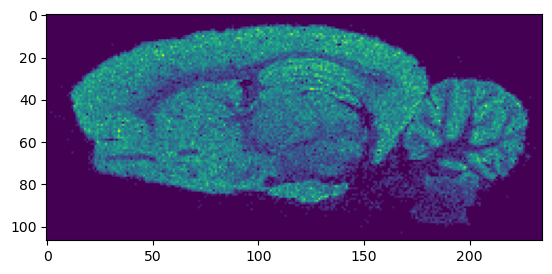

In [122]:
plt.imshow(tmp_array[237].reshape(adat.obs['y'].max()+1, -1))

In [ ]:
tmp = utils.coloc_preprocessing(brain_ads['2022-08-24_00h20m06s'])

In [84]:
adat.var

,formula,adduct,ionFormula,ion,mz,msm,rhoSpatial,rhoSpectral,moc,fdr,offSample,isotopeImages,colocCoeff,moleculeNames,moleculeIds,intensity
formula_adduct,,,,,,,,,,,,,,,,
C42H82NO8P+Na,C42H82NO8P,+Na,C42H82NO8PNa,C42H82NO8P+Na+,782.567090,0.942587,0.954109,0.981919,0.998802,0.033333,False,"[{'mz': 782.5670895885813, 'url': 'https://s3....",None,"[PC(14:0/20:1(11Z)), PC(14:1(9Z)/20:0), PC(16:...","[HMDB0007879, HMDB0007911, HMDB0007971, HMDB00...",172.843750
C42H82NO8P+K,C42H82NO8P,+K,C42H82NO8PK,C42H82NO8P+K+,798.541029,0.941862,0.982779,0.990116,0.998526,0.042857,False,"[{'mz': 798.5410294442759, 'url': 'https://s3....",None,"[PC(14:0/20:1(11Z)), PC(14:1(9Z)/20:0), PC(16:...","[HMDB0007879, HMDB0007911, HMDB0007971, HMDB00...",463.500000
C41H83N2O6P+K,C41H83N2O6P,+K,C41H83N2O6PK,C41H83N2O6P+K+,769.562095,0.922507,0.971342,0.975669,0.998405,0.042857,False,"[{'mz': 769.5620945400691, 'url': 'https://s3....",None,"[SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...","[HMDB0012088, HMDB0012089, HMDB0062559]",72.500000
C37H71O8P+K,C37H71O8P,+K,C37H71O8PK,C37H71O8P+K+,713.451867,0.907610,0.981760,0.980270,0.998728,0.042857,False,"[{'mz': 713.4518667581781, 'url': 'https://s3....",None,"[PA(16:0/18:1(11Z)), PA(16:0/18:1(9Z)), 9-Octa...","[HMDB0007858, HMDB0007859, HMDB0031130, HMDB01...",86.546875
C43H76NO7P+Na,C43H76NO7P,+Na,C43H76NO7PNa,C43H76NO7P+Na+,772.525223,0.905913,0.963896,0.977953,0.998662,0.059375,False,"[{'mz': 772.5252231593009, 'url': 'https://s3....",None,"[PE(20:4(5Z,8Z,11Z,14Z)/P-18:1(11Z)), PE(20:4(...","[HMDB0009413, HMDB0009414, HMDB0009446, HMDB00...",229.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C44H80O5+K,C44H80O5,+K,C44H80O5K,C44H80O5+K+,727.563789,0.667312,0.000292,0.826276,0.995035,0.199009,False,"[{'mz': 727.5637888022283, 'url': 'https://s3....",None,"[DG(22:1n9/0:0/18:2n6), DG(22:1(13Z)/19:2(10Z,...","[HMDB0056253, HMDB0116449]",0.748779
C48H84NO7P+K,C48H84NO7P,+K,C48H84NO7PK,C48H84NO7P+K+,856.561775,0.667181,0.009195,0.819448,0.991649,0.199009,False,"[{'mz': 856.5617748336741, 'url': 'https://s3....",None,"[PC(22:5(4Z,7Z,10Z,13Z,16Z)/P-18:1(11Z)), PC(2...","[HMDB0008687, HMDB0008688, HMDB0008720, HMDB00...",0.665894
C52H100NO8P+K,C52H100NO8P,+K,C52H100NO8PK,C52H100NO8P+K+,936.681905,0.666742,0.029271,0.806536,0.972113,0.199231,False,"[{'mz': 936.6819048453883, 'url': 'https://s3....",None,"[PC(20:1(11Z)/24:1(15Z)), PC(20:2(11Z,14Z)/24:...","[HMDB0008323, HMDB0008355, HMDB0008547, HMDB00...",0.865112


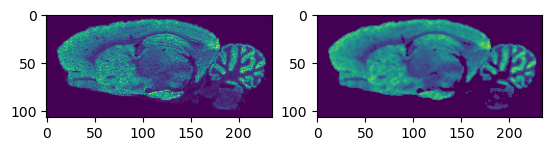

In [107]:
ds_id = '2022-07-19_19h29m24s'
conv_data = utils.coloc_preprocessing(brain_ads[ds_id])

fig, (ax1, ax2) = plt.subplots(ncols=2)

c = 2

ax1.imshow(brain_ads[ds_id].X.transpose().reshape((brain_ads[ds_id].X.shape[1], brain_ads[ds_id].obs['y'].max()+1, -1))[c])
ax2.imshow(conv_data.reshape((brain_ads[ds_id].X.shape[1], brain_ads[ds_id].obs['y'].max()+1, -1))[c])

# ASMS Poster plots

In [46]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

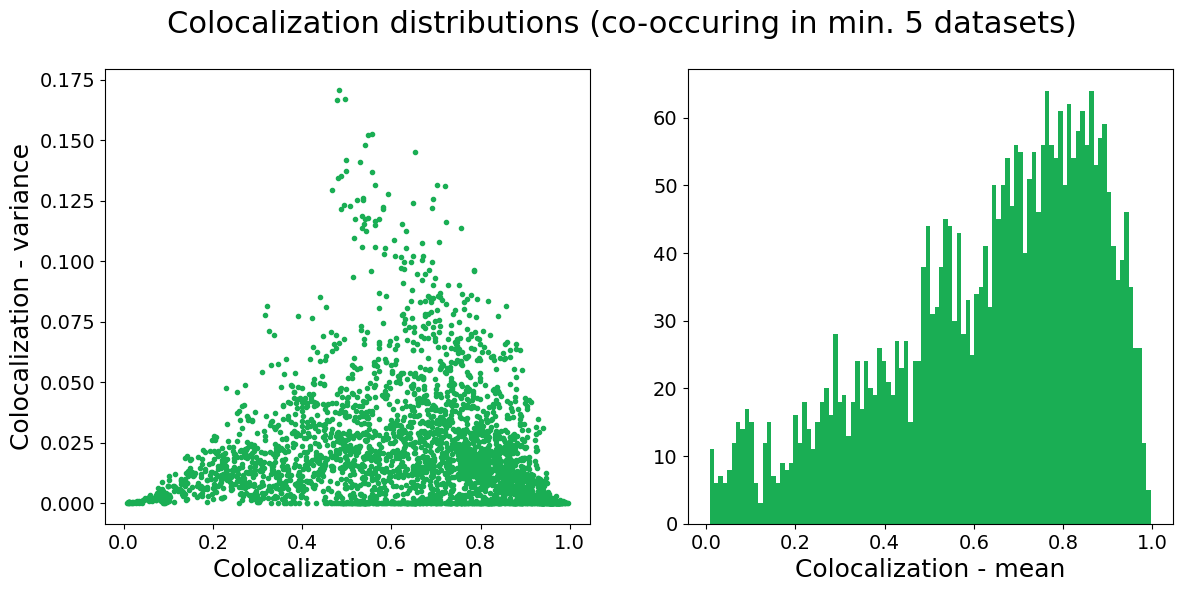

In [105]:
mean_l = []
var_l = []
cv_l = []
min_datasets = 5

for x in ii_dict.values():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_l.append(np.mean(x))
            var_l.append(np.var(x))
            cv_l.append(np.std(x)/np.mean(x))

cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35*cm, 15*cm))
plt.suptitle('Colocalization distributions (co-occuring in min. 5 datasets)')
            
ax1.plot(mean_l, var_l, '.', color='#1aae54')
ax1.set_xlabel('Colocalization - mean')
ax1.set_ylabel('Colocalization - variance')

ax2.hist(mean_l, bins=100, color='#1aae54')
ax2.set_xlabel('Colocalization - mean')

plt.savefig("plots/coloc_dist.png", dpi=400)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


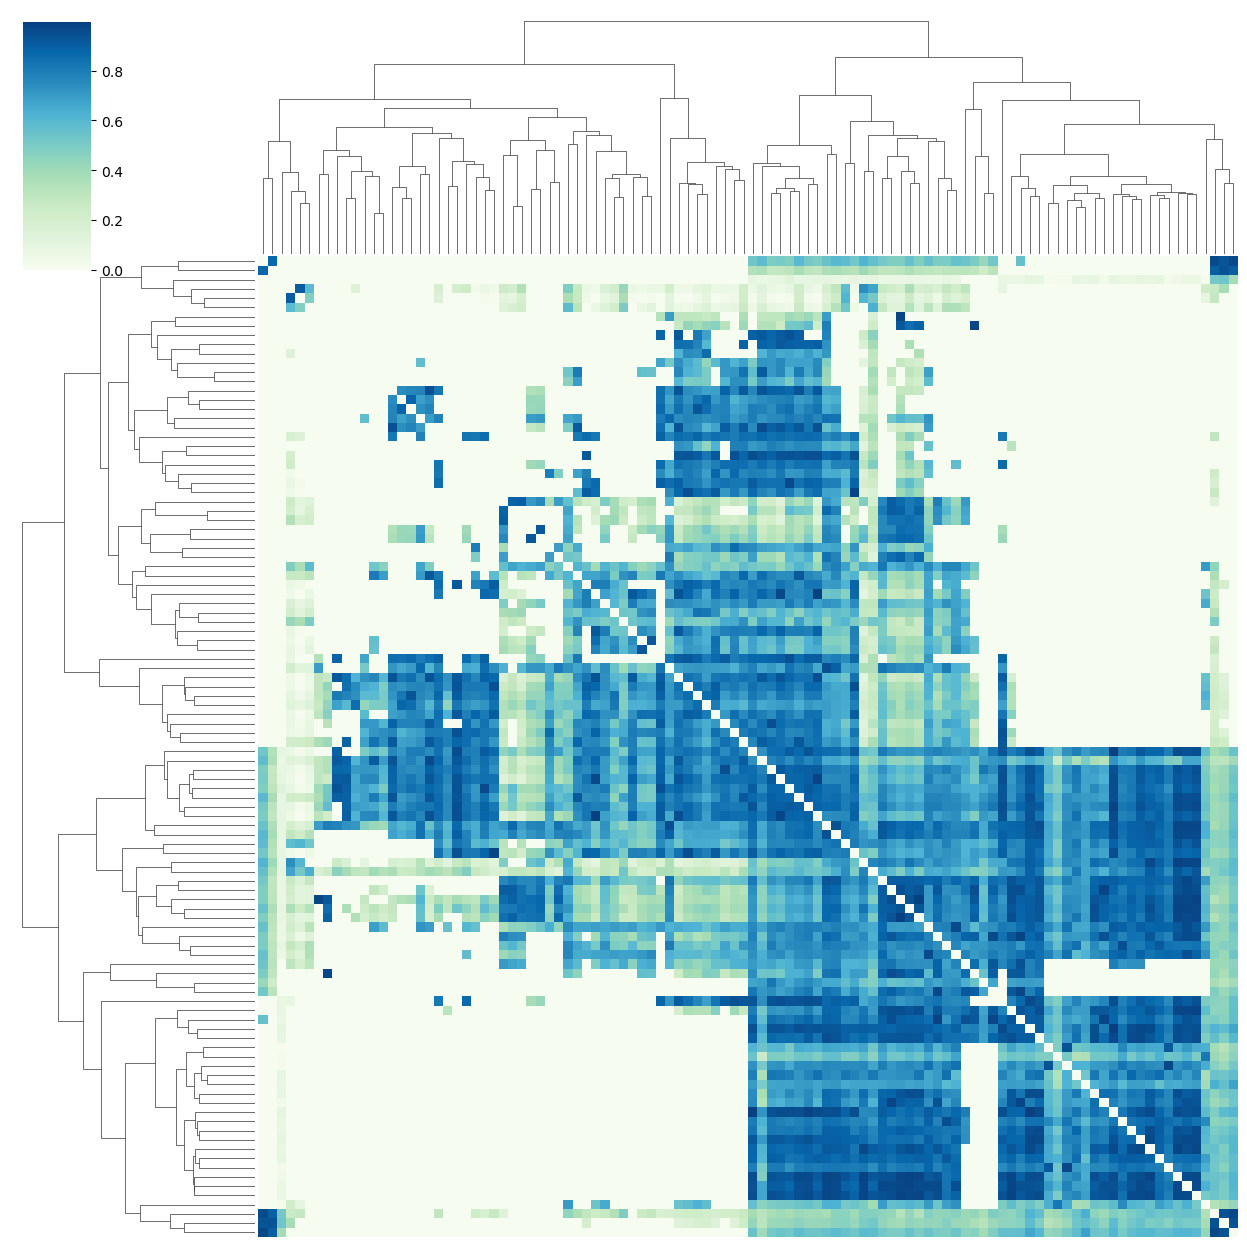

In [21]:
mean_d = {}
min_datasets = 5

counter = 0
for ii, x in ii_dict.items():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_d[ii] = np.mean(x)
            
selected_ions = list(set([item for tuple in mean_d for item in tuple]))

df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)

for k, v in mean_d.items():
    df.loc[k[0], k[1]] = v
    df.loc[k[1], k[0]] = v

cm = 1/2.54
a = sns.clustermap(df, figsize=(35*cm, 35*cm), cmap='GnBu')
a.ax_heatmap.set_xticks([])
a.ax_heatmap.set_yticks([])

plt.savefig("plots/coloc_heatmap.png", dpi=400)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Network neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.438e-17 U_stat=2.368e+07


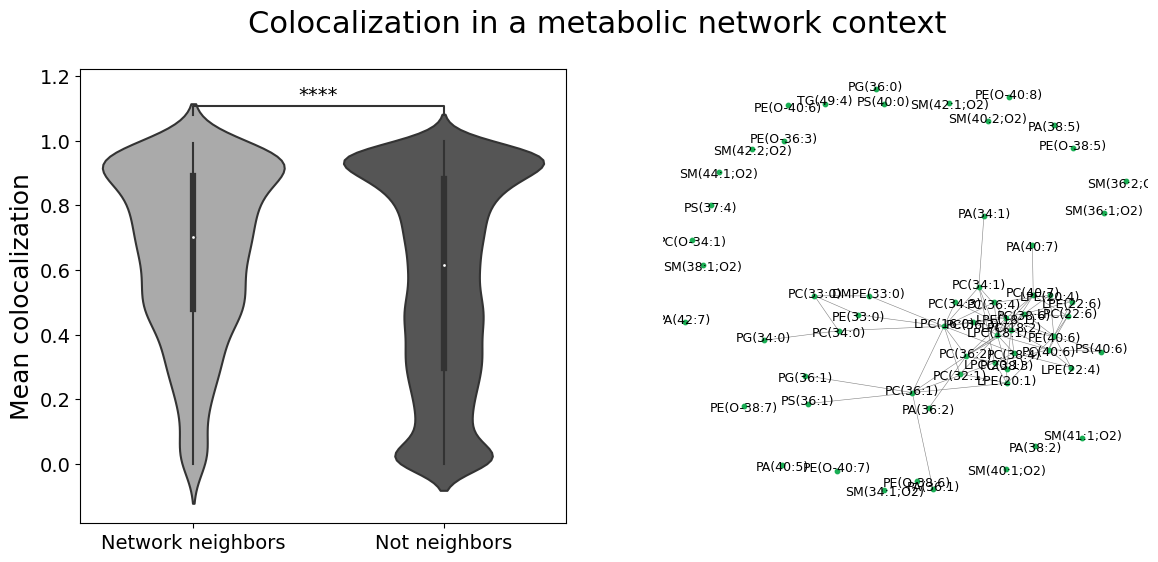

In [106]:
def catch_sp(g, source, target):
    try:
        return nx.shortest_path_length(g, source, target)
    except:
        return np.inf
    
edge_cor = []
nedge_cor = []
eds_l = []
nds_l = []

for dsid in lx_nets.keys():
    
    ls = coloc_dict[dsid]
    #led = list(ig.edges)
    ig = lx_nets[dsid]

    max_hops = 1
    node_list = list(lx_nets[dsid].nodes)
    for l1 in range(len(node_list)):
        for l2 in range(l1+1, len(node_list)):
            if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                eds_l.append(dsid)
            else:
                nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                nds_l.append(dsid)

tmp_dat = pd.concat([
    pd.DataFrame({'cor': edge_cor, 'grouping': 'Network neighbors', 'dataset': eds_l}),
    pd.DataFrame({'cor': nedge_cor, 'grouping': 'Not neighbors', 'dataset': nds_l}),
          ])

cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35*cm, 15*cm))

plt.suptitle('Colocalization in a metabolic network context')
            
sns.violinplot(data=tmp_dat, x='grouping', y='cor', ax=ax1, palette='binary')

annotator = Annotator(ax1, 
                      [('Network neighbors', 'Not neighbors')], 
                      data=tmp_dat, x='grouping', y='cor', 
                      order=['Network neighbors', 'Not neighbors'])
annotator.configure(test="Mann-Whitney")
annotator.apply_and_annotate()
ax1.set_ylabel('Mean colocalization')
ax1.set_xlabel('')

pos = nx.spring_layout(ion_net, k=.25)
nx.draw_networkx_nodes(ion_net, node_color='#1aae54', node_size=10, pos=pos, ax=ax2)
nx.draw_networkx_edges(ion_net, width=.4, pos=pos, ax=ax2, edge_color='grey')
nx.draw_networkx_labels(ion_net, pos=nudge(pos, 0, 0.01),
                            labels={k: v['sum_species'].index[0] for k, v in dict(ion_net.nodes(data=True)).items()},
                            font_size=9, ax=ax2)
ax2.axis('off')

plt.savefig("plots/networks.png", dpi=400)
 
plt.show()